In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'studentsperformance'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

engine.dispose()

performance = pd.read_sql_query('select * from studentsperformance',con=engine)
performance.head(10)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
5,female,group B,associate's degree,standard,none,71,83,78
6,female,group B,some college,standard,completed,88,95,92
7,male,group B,some college,free/reduced,none,40,43,39
8,male,group D,high school,free/reduced,completed,64,64,67
9,female,group B,high school,free/reduced,none,38,60,50


In [3]:
#Check cleanliness of data
performance.isnull().sum()*100/performance.isnull().count()

gender                         0.0
race/ethnicity                 0.0
parental level of education    0.0
lunch                          0.0
test preparation course        0.0
math score                     0.0
reading score                  0.0
writing score                  0.0
dtype: float64

1. Are there any differences between the genders, ethnicities, and parental level of education with respect to their performances in exams?

In [4]:
performance.groupby('gender').mean()

,math score,reading score,writing score
gender,,,
female,63.633205,72.608108,72.467181
male,68.728216,65.473029,63.311203


Males scored on average 5 points higher than females is math, but 7 lower in reading and 9 lower in writing.

In [5]:
performance.groupby('race/ethnicity').mean()

,math score,reading score,writing score
race/ethnicity,,,
group A,61.629213,64.674157,62.674157
group B,63.452632,67.352632,65.600000
group C,64.463950,69.103448,67.827586
group D,67.362595,70.030534,70.145038
group E,73.821429,73.028571,71.407143


The scores across the board go up as the list descends, with group E performing highest in all categories.

In [6]:
performance.groupby('parental level of education').mean()

,math score,reading score,writing score
parental level of education,,,
associate's degree,67.882883,70.927928,69.896396
bachelor's degree,69.389831,73.000000,73.381356
high school,62.137755,64.704082,62.448980
master's degree,69.745763,75.372881,75.677966
some college,67.128319,69.460177,68.840708
some high school,63.497207,66.938547,64.888268


Students with high school educated parents fared worse than the rest of the group, while students of parents with a bachelor's or master's scored highest on average. 

In [7]:
#Let's test whether these differences are significant. 
levels= performance['parental level of education'].unique()

for var in ['math score', 'reading score', 'writing score']:
    print('---------------------')
    print('Category in testing: {}'.format(var))
    print('---------------------')
    for i in range(0, len(levels)):
        for j in range(i+1, len(levels)):
            print('ttest between groups {} and {}:'.format(levels[i], levels[j]))
            print(stats.ttest_ind(
                performance[performance['parental level of education'] == levels[i]][var], 
                performance[performance['parental level of education'] == levels[j]][var]))          

---------------------
Category in testing: math score
---------------------
ttest between groups bachelor's degree and some college:
Ttest_indResult(statistic=1.3702352829617477, pvalue=0.17151224218471559)
ttest between groups bachelor's degree and master's degree:
Ttest_indResult(statistic=-0.14868196568849312, pvalue=0.8819757824867702)
ttest between groups bachelor's degree and associate's degree:
Ttest_indResult(statistic=0.8786641889793243, pvalue=0.38020757818036177)
ttest between groups bachelor's degree and high school:
Ttest_indResult(statistic=4.236143622484822, pvalue=2.9965345853843376e-05)
ttest between groups bachelor's degree and some high school:
Ttest_indResult(statistic=3.196718602676573, pvalue=0.0015409192922812146)
ttest between groups some college and master's degree:
Ttest_indResult(statistic=-1.2356334215824571, pvalue=0.21761956810347416)
ttest between groups some college and associate's degree:
Ttest_indResult(statistic=-0.5426842696247527, pvalue=0.587618280

2. Are there any differences between the lunch types with respect to their performances in exams? If there are, how do you explain this?

In [8]:
performance.groupby('lunch').mean()

,math score,reading score,writing score
lunch,,,
free/reduced,58.921127,64.653521,63.022535
standard,70.034109,71.654264,70.823256


In [16]:
stats.ttest_ind(performance[performance['lunch'] == 'free/reduced'][['math score', 'reading score', 'writing score']], 
               performance[performance['lunch'] == 'standard'][['math score', 'reading score', 'writing score']])

Ttest_indResult(statistic=array([-11.83718047,  -7.45105647,  -8.0097842 ]), pvalue=array([2.41319560e-30, 2.00279665e-13, 3.18618958e-15]))

There is a sizeable difference between lunch types and exam scores, which is likely due to the lurking variable of socioeconomic status and access to educational resources.

3. Does the test preparation course seem to have an effect on the exam performances?

In [9]:
performance.groupby('test preparation course').mean()

,math score,reading score,writing score
test preparation course,,,
completed,69.695531,73.893855,74.418994
none,64.077882,66.534268,64.504673


In [10]:
stats.ttest_ind(performance[performance['test preparation course'] == 'completed']['math score'], 
         performance[performance['test preparation course'] == 'none']['math score'])

Ttest_indResult(statistic=5.704616417349102, pvalue=1.5359134607147415e-08)

Yes, the math scores, which had the smallest difference in exam scores with regards to test prep, displayed a significant difference with a very low p-value. 

4. Which 2 exam scores are most correlated with each other?

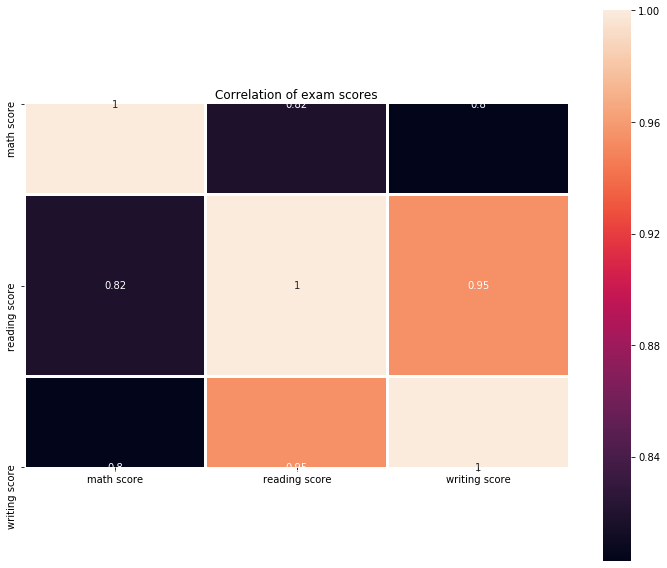

In [11]:
corrperformance= performance.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(corrperformance, annot=True, square=True, linewidths= 2).set_title('Correlation of exam scores')

plt.tight_layout()
plt.show()

Reading and writing are the most highly correlated, with a 0.95 coefficient. 